In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import sys
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

In [3]:
import itertools
from sklearn.model_selection import KFold
from statsmodels.tsa.stattools import acf

In [4]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings
from loaders import load_sabes
from segmentation import reach_segment_sabes
from decoders import lr_decode_windowed, expand_state_space

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
with open('/mnt/Secondary/data/postprocessed/timescale_dimreduc_df.dat', 'rb') as f:
    df = pickle.load(f)
df = pd.DataFrame(df)

In [11]:
# For each data file and combination of decoder args, get the average single unit autocorrelation times and the subspace angles across dimension
loader_args = [{'bin_width':100, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'},
               {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'},
               {'bin_width':25, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'}]

for bin_width in [25, 50, 100]:
    for window_length in [5, 10, 20]:
        loader_args.append({'bin_width':bin_width, 'filter_fn':'window', 'filter_kwargs':{'window_name':'hann', 'window_length':window_length}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'})

dims = np.array([2, 4, 6, 10])
data_files = np.unique(df['data_file'].values)

In [25]:
def get_acf_time(x, dt, thresh=0.1):
    ac = acf(x, adjusted=True)
    try:
        idx = np.argwhere(ac < thresh)[0][0]
    except IndexError:
        idx = len(ac)
    return dt * idx

0it [00:00, ?it/s]

> /tmp/ipykernel_26465/1430729888.py(7)get_acf_time()
      3     try:
      4         idx = np.argwhere(ac < thresh)[0][0]
      5     except IndexError:
      6         pdb.set_trace()
----> 7     return dt * idx



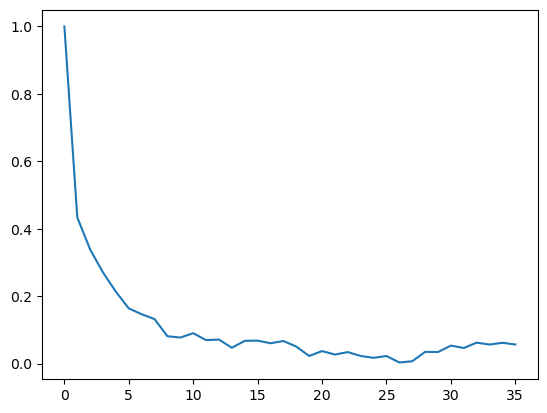

0.001
*** AttributeError: module 'numpy' has no attribute 'arwehre'
0.003286555779596947


1it [00:47, 47.24s/it]
0it [00:47, ?it/s]


In [24]:
rl = []
for i, loader_arg in tqdm(enumerate(loader_args)):
    for j, data_file in tqdm(enumerate(data_files)):
        dat = load_sabes('%s/%s' % ('/mnt/Secondary/data/sabes', data_file), **loader_arg)
        X = dat['spike_rates'].squeeze()
        act = np.array([[get_acf_time(X[:, k], loader_arg['bin_width'], t) for k in range(X.shape[1])] for t in [0.1, 0.05, 0.01, 1/np.e]])
        for k, dim in enumerate(dims):
            dpca = apply_df_filters(df, data_file=data_file, loader_args=loader_arg, dim=dim, dimreduc_method='PCA')
            dfca = apply_df_filters(df, data_file=data_file, loader_args=loader_arg, dim=dim, dimreduc_method='LQGCA')
            assert(dpca.shape[0] == 5)
            assert(dfca.shape[0] == 5)
            ssa_mean = []
            ssa_min = []
            for h in range(5):
                coef_pca = dpca.iloc[h]['coef']
                coef_fca = dfca.iloc[h]['coef']
                ssa_mean.append(np.mean(scipy.linalg.subspace_angles(coef_pca, coef_fca)))
                ssa_min.append(np.min(scipy.linalg.subspace_angles(coef_pca, coef_fca)))
            ssa_mean = np.mean(ssa_mean)
            ssa_min = np.mean(ssa_min)

            r = {}
            r['loader_idx'] = i
            r['data_file'] = data_file
            r['dim'] = dim
            r['act'] = act
            r['ssa_mean'] = ssa_mean
            r['ssa_min'] = ssa_min
            rl.append(r)

In [5]:
# with open('timescale_ssa_tmp.dat', 'wb') as f:
#     f.write(pickle.dumps(rl))
with open('timescale_ssa_tmp.dat', 'rb') as f:
    rl = pickle.load(f)

In [6]:
rl = pd.DataFrame(rl)

In [7]:
rl.iloc[0]['act'].shape

(4, 97)

In [17]:
# Average across data files, choose a fixed dimension, plot the d=6 subspace angle as a function of the average autocorrelation time
X = np.zeros((len(loader_args), len(data_files)))
Y1 = np.zeros((len(loader_args), len(data_files)))
Y2 = np.zeros((len(loader_args), len(data_files)))

dim = 6

for i, loader_arg in enumerate(loader_args):

    x = np.zeros(len(data_files))
    y1 = np.zeros(len(data_files))
    y2 = np.zeros(len(data_files))

    for j, data_file in enumerate(data_files):

        d = apply_df_filters(rl, data_file=data_file, loader_idx=i, dim=dim)
        assert(d.shape[0] == 1)
        x[j] = np.mean(d.iloc[0]['act'][-1, :])
        y1[j] = d['ssa_mean'].values[0]
        y2[j] = d['ssa_min'].values[0]
    
    X[i, :] = x
    Y1[i, :] = y1
    Y2[i, :] = y2

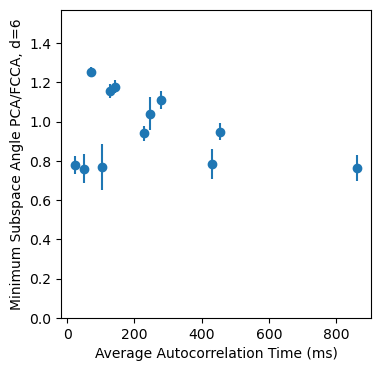

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.errorbar(np.mean(X, axis=1), np.mean(Y2, axis=1), yerr=np.std(Y2, axis=1), linestyle="", marker='o')
ax.set_ylim([0, np.pi/2])
ax.set_xlabel('Average Autocorrelation Time (ms)')
ax.set_ylabel('Minimum Subspace Angle PCA/FCCA, d=6')
fig.savefig('/home/akumar/nse/neural_control/figs/timescale_ssa.pdf', bbox_inches='tight', pad_inches=0)


In [41]:
scipy.stats.linregress(X, Y2b)

LinregressResult(slope=-0.0002252836496959664, intercept=1.0138491083937367, rvalue=-0.2883198947343911, pvalue=0.36345170133737525, stderr=0.0002365970536115382, intercept_stderr=0.08026742695024619)

In [30]:
# How many single units in M1/S1
data_files = glob.glob('/mnt/Secondary/data/sabes/*.mat')
M1_su = []
S1_su = []
for data_file in data_files:
    dat = load_sabes(data_file, region='M1')
    M1_su.append(dat['spike_rates'].squeeze().shape[1])
    dat = load_sabes(data_file, region='S1')
    S1_su.append(dat['spike_rates'].squeeze().shape[1])

0
96
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
96
96
96
96
96
96
96
96
96
96


In [32]:
min(M1_su)

97

In [33]:
max(M1_su)

200

In [36]:
S1_su = np.array(S1_su)[np.array(S1_su) > 0]

In [37]:
min(S1_su)

86

In [38]:
max(S1_su)

187